# Import

In [96]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [97]:

# Lista dostupnih GPU-ova
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Ograničite TensorFlow da koristi samo prvi GPU (opciono)
        tf.config.set_visible_devices(gpus[0], 'GPU')
        
        # Postavite ograničenje memorije (opciono)
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU uspešno podešen za TensorFlow.")
    except RuntimeError as e:
        print(e)
else:
    print("GPU nije dostupan.")


GPU nije dostupan.


# preprocess

In [98]:
# Parametri za slike
img_height, img_width = 128, 128  # Dimenzije slika koje model očekuje
batch_size = 32                   # Broj slika po batch-u

# Putanje do foldera sa treninzima i validacijama
train_dir = "mydata/train"
validation_dir = "mydata/test"

# Kreiranje ImageDataGenerator objekata za augmentaciju i normalizaciju
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,        # Normalizacija piksela
    rotation_range=20,          # Random rotacije
    width_shift_range=0.2,      # Horizontalni pomak
    height_shift_range=0.2,     # Vertikalni pomak
    shear_range=0.2,            # Promena ugla
    zoom_range=0.2,             # Zoomiranje
    horizontal_flip=True,       # Horizontalno okretanje
    fill_mode="nearest",        # Popunjavanje praznina
    validation_split=0.2        # Opciono: podela na train/valid iz istog foldera
)

validation_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0         # Samo normalizacija za validaciju
)

# Kreiranje train generatora
training_set = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'  # Koristi 'categorical' za više klasa
)

# Kreiranje validation generatora
validation_set = validation_datagen.flow_from_directory(
    directory=validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)



Found 2346 images belonging to 8 classes.
Found 75 images belonging to 8 classes.


In [99]:

# Provera klasa
training_set.class_indices

{'complex': 0,
 'frog_eye_leaf_spot': 1,
 'healthy': 2,
 'multiple_diseases': 3,
 'powdery_mildew': 4,
 'rust': 5,
 'scab': 6,
 'scab frog_eye_leaf_spot': 7}

In [100]:
validation_set.class_indices

{'complex': 0,
 'frog_eye_leaf_spot': 1,
 'healthy': 2,
 'multiple_diseases': 3,
 'powdery_mildew': 4,
 'rust': 5,
 'scab': 6,
 'scab frog_eye_leaf_spot': 7}

To avoid Overshooting Loss function

1. Choose small learning rate default 0.001 here we have taken 0.0001
2. There may be chance of underfitting so increase number of neuron
3. Add more Convolutional Layer to extract more feature from images there may be possibilty that model unable to capture relevant feature or model is confusing due to lack of feature so feed with more feature

# model

In [101]:
cnn = tf.keras.models.Sequential()

cnn.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',input_shape=[128,128,3]))
cnn.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu')) # ovaj nema padding jer ima prethodni i da bi model bio brzi
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

cnn.add(tf.keras.layers.Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
cnn.add(tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

cnn.add(tf.keras.layers.Conv2D(filters=128,kernel_size=3,padding='same',activation='relu'))
cnn.add(tf.keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

cnn.add(tf.keras.layers.Conv2D(filters=256,kernel_size=3,padding='same',activation='relu'))
cnn.add(tf.keras.layers.Conv2D(filters=256,kernel_size=3,activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

cnn.add(tf.keras.layers.Conv2D(filters=512,kernel_size=3,padding='same',activation='relu'))
cnn.add(tf.keras.layers.Conv2D(filters=512,kernel_size=3,activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))


cnn.add(tf.keras.layers.Dropout(0.25))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=1500,activation='relu'))
cnn.add(tf.keras.layers.Dropout(0.4)) #To avoid overfitting
#Output Layer
cnn.add(tf.keras.layers.Dense(units=8,activation='softmax'))

## train

In [102]:
cnn.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [103]:
cnn.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 126, 126, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 63, 63, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 61, 61, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 30, 30, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1500)           │     3,073,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1500)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 8)              │        12,008 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,797,732 (29.75 MB)

 Trainable params: 7,797,732 (29.75 MB)

 Non-trainable params: 0 (0.00 B)

In [104]:
training_history = cnn.fit(x=training_set, validation_data=validation_set, epochs=10)

Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.1473 - loss: 2.0717 - val_accuracy: 0.1333 - val_loss: 2.0971
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.1554 - loss: 2.0575 - val_accuracy: 0.1600 - val_loss: 1.9801
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.2235 - loss: 1.9474 - val_accuracy: 0.2533 - val_loss: 1.8134
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.2442 - loss: 1.8415 - val_accuracy: 0.3200 - val_loss: 1.7578
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.2594 - loss: 1.8524 - val_accuracy: 0.3333 - val_loss: 1.7321
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.2665 - loss: 1.8501 - val_accuracy: 0.2800 - val_loss: 1.7560
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.2554 - loss: 1.8210 - val_accuracy: 0.2533 - val_loss: 1.7987
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.2636 - loss: 1.8302 - val_accuracy: 0.3467 - val_loss

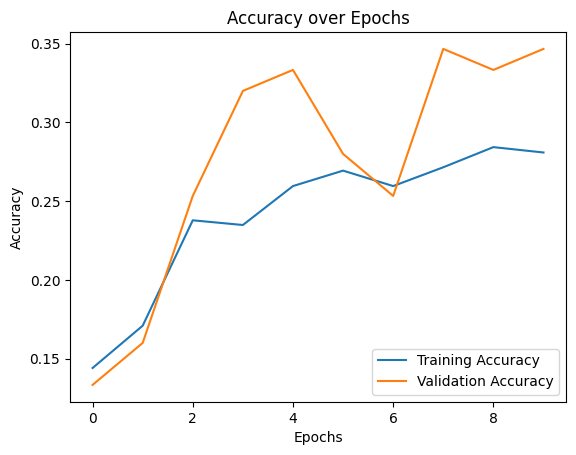

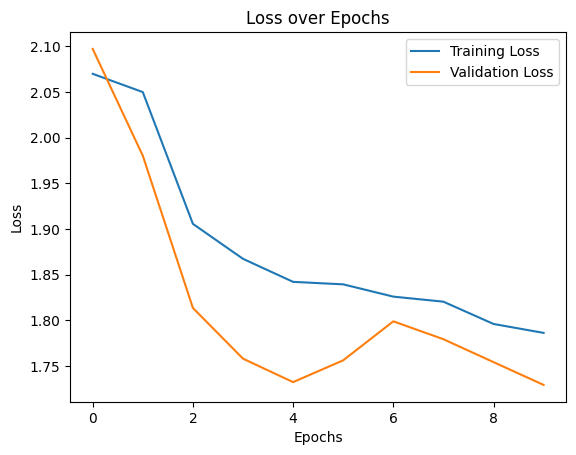

In [111]:
plt.plot(training_history.history['accuracy'], label='Training Accuracy')
plt.plot(training_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Trening i validacioni gubitak
plt.plot(training_history.history['loss'], label='Training Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [112]:
cnn.save('./my_model.h5')  


# Evaluating Model

In [114]:

#Training set Accuracy
train_loss, train_acc = cnn.evaluate(training_set)
print('Training accuracy:', train_acc)

74/74 ━━━━━━━━━━━━━━━━━━━━ 20s 263ms/step - accuracy: 0.3222 - loss: 1.7559
Training accuracy: 0.3069053590297699


In [113]:
#Validation set Accuracy
val_loss, val_acc = cnn.evaluate(validation_set)
print('Validation accuracy:', val_acc)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.3296 - loss: 1.7524
Validation accuracy: 0.3466666638851166


In [115]:
training_history.history #Return Dictionary of history

{'accuracy': [0.14407502114772797,
  0.17092923820018768,
  0.23785166442394257,
  0.2348678559064865,
  0.2595908045768738,
  0.26939472556114197,
  0.2595908045768738,
  0.2715260088443756,
  0.28431373834609985,
  0.2809036672115326],
 'loss': [2.069807767868042,
  2.0497817993164062,
  1.905453085899353,
  1.8671660423278809,
  1.8419444561004639,
  1.8392184972763062,
  1.8257691860198975,
  1.8202474117279053,
  1.7958316802978516,
  1.7860455513000488],
 'val_accuracy': [0.13333334028720856,
  0.1599999964237213,
  0.25333333015441895,
  0.3199999928474426,
  0.3333333432674408,
  0.2800000011920929,
  0.25333333015441895,
  0.3466666638851166,
  0.3333333432674408,
  0.3466666638851166],
 'val_loss': [2.097071647644043,
  1.9801054000854492,
  1.813368320465088,
  1.7578226327896118,
  1.7321256399154663,
  1.7560091018676758,
  1.7987092733383179,
  1.7791424989700317,
  1.754045844078064,
  1.72906494140625]}